# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [4]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *
from src.multitask_transformer import *

In [5]:
config = mlm_config();

In [6]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
data_save_name = 'multi_data_idxenc.pkl'

## MSKLM

In [7]:
data = load_data(numpy_path, data_save_name, bs=1)
vocab = data.vocab
learn = multitask_model_learner(data, config.copy())

## Load existing

In [8]:
saved_models = get_files(numpy_path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('data/numpy/combined_tracks/models/MusicTransformer.pth'),
 PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')]

In [9]:
load_path = saved_models[1];
learn.load(load_path.stem);
load_path

PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')

### Predictions - Get midi file

In [10]:
data_dir = 'data/midi/examples/'
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')]

In [11]:
idx = 2
file = midi_files[idx]; file

PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid')

In [12]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

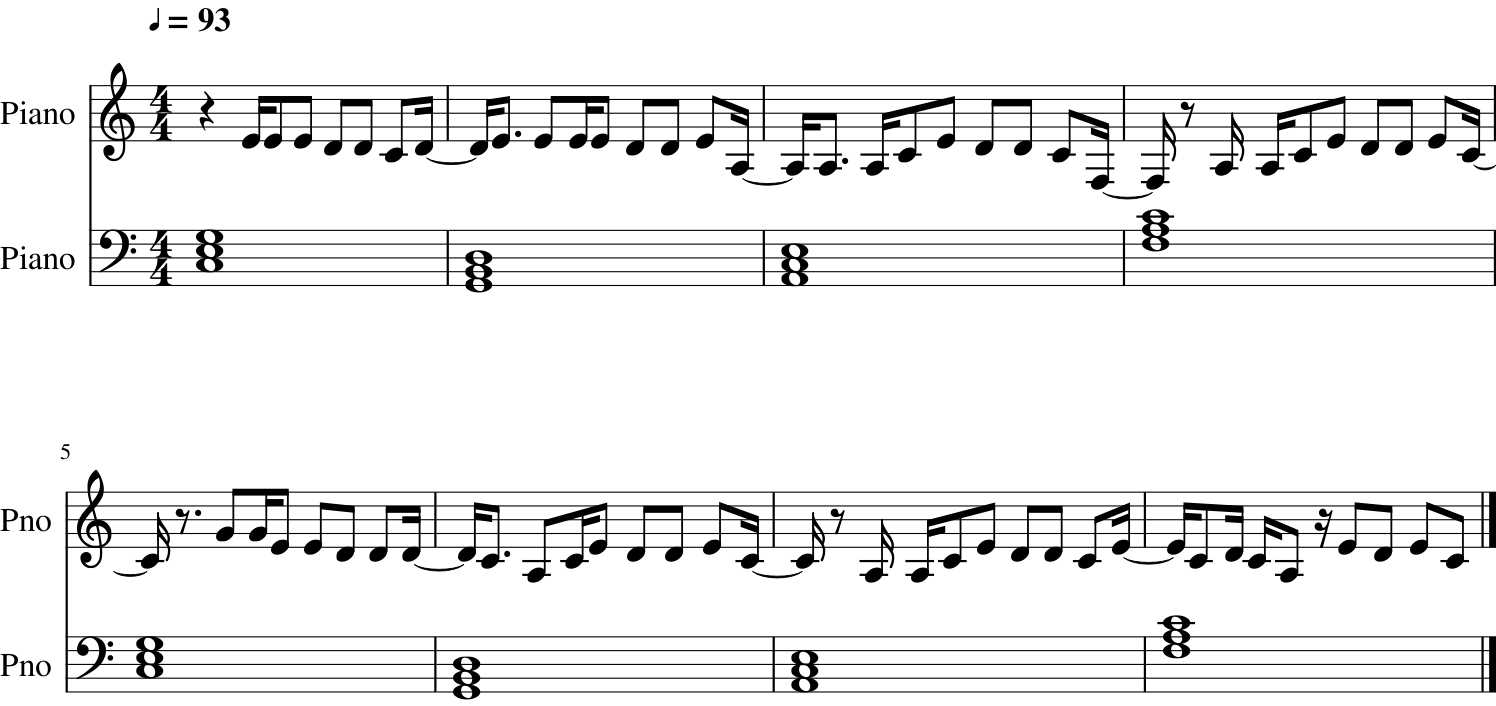

In [13]:
item.show()

In [14]:
item.play()

## Predict Mask

In [15]:
def predict_mask(self, masked_item:MusicItem, pos=None,
                temperatures:float=(1.0,1.0),
                top_k=20, top_p=0.8):
    x = masked_item.to_tensor()
    pos = masked_item.get_pos_tensor()
    y = torch.tensor([0])
    vocab = self.data.vocab
    self.model.reset()
    mask_idxs = (x == vocab.mask_idx).nonzero().view(-1)

    with torch.no_grad():
        for midx in progress_bar(mask_idxs, leave=True):
            # Using original positions, otherwise model gets too off track
    #         pos = torch.tensor(-position_enc(xb[0].cpu().numpy()), device=xb.device)[None]

            # Next Word
            res = self.pred_batch(batch=({ 'msk': { 'x': x[None], 'pos': pos[None] } }, y) )['msk'][0]
            res = F.softmax(res[midx], dim=-1) # task1, task2 - (bs x ts x vocab)

            # Don't allow any special tokens (as we are only removing notes and durations)
            res[vocab.bos_idx] = 0.
            res[vocab.sep_idx] = 0.
            res[vocab.stoi[EOS]] = 0

            # Use first temperatures value if last prediction was duration
            prev_idx = x[midx-1]
            temperature = temperatures[0] if vocab.is_duration(prev_idx) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()
            #         idx = res.argmax()

            x[midx] = idx

    return MusicItem(x.cpu().numpy(), vocab)

#### Regenerate durations

In [16]:
# duration mask
dur_item = item.mask_duration()

In [17]:
dur_pred = learn.predict_mask(dur_item, temperatures=(0.8,0.8), top_k=40, top_p=0.6)

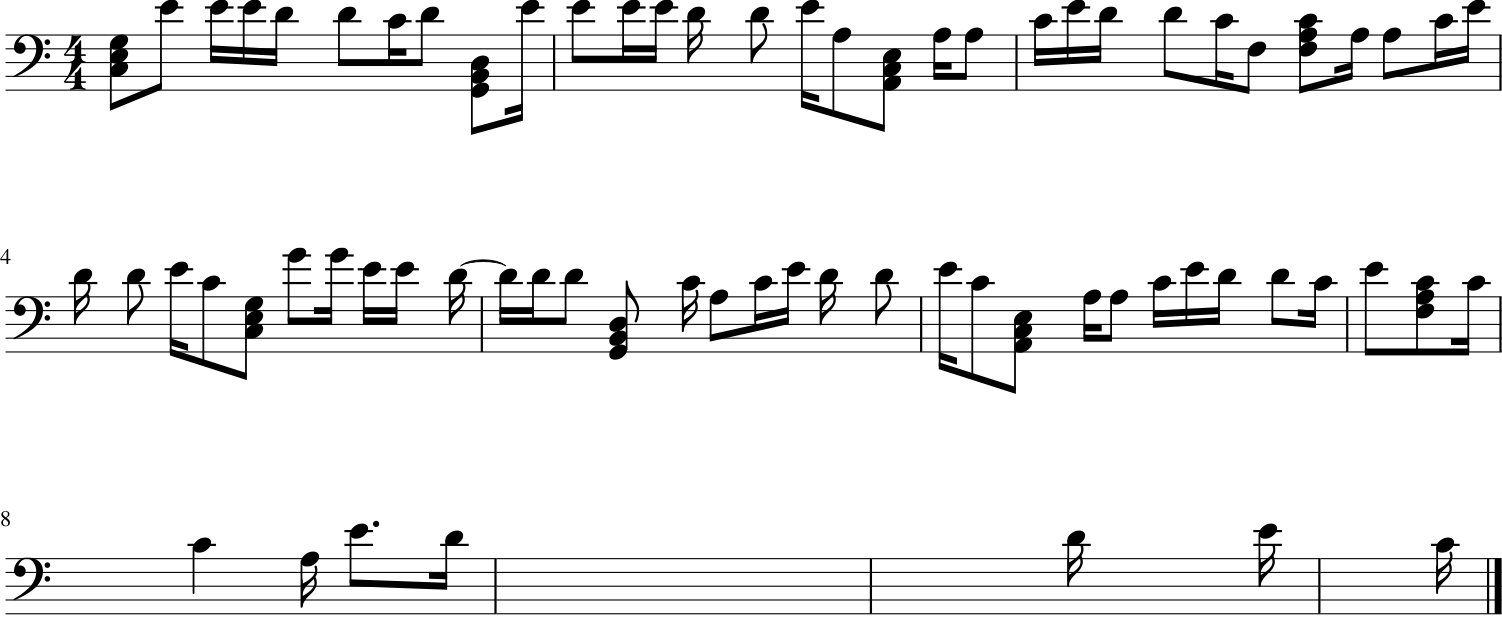

In [18]:
dur_pred.show()

#### Regenerate Notes

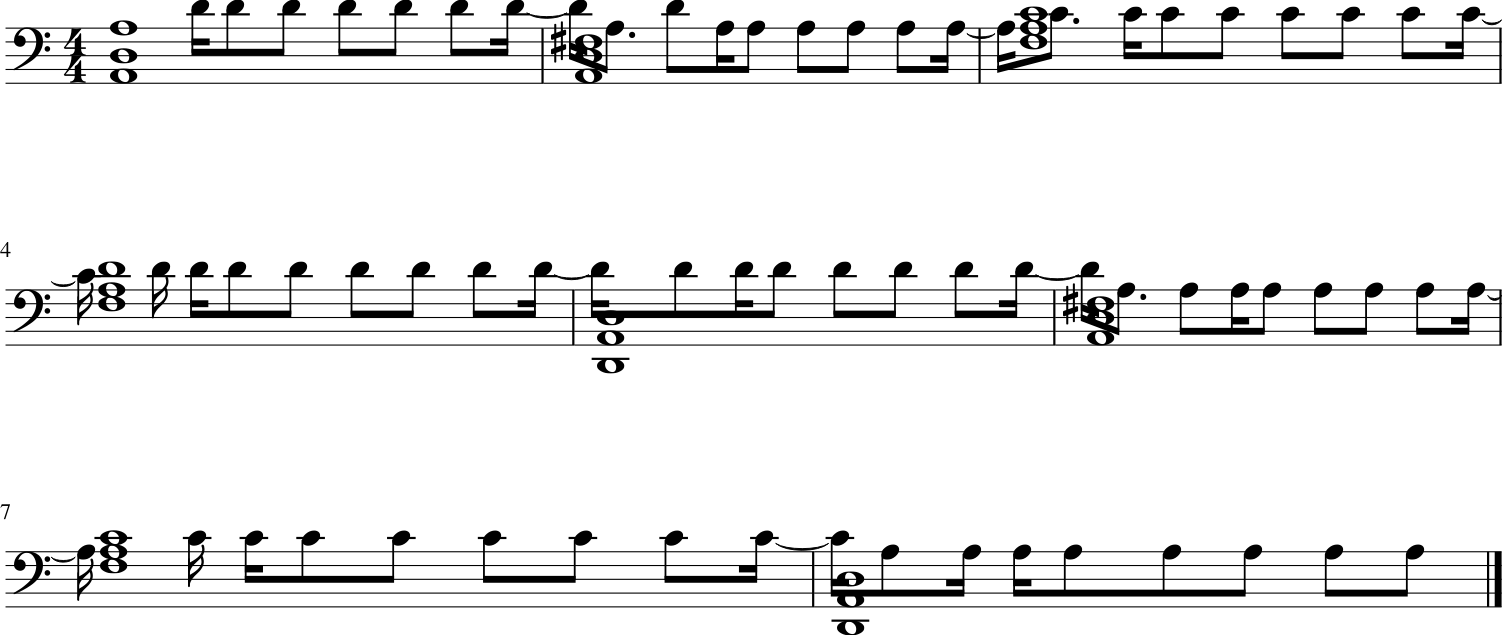

In [19]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
note_item = item.mask_notes()
pred_note = learn.predict_mask(note_item)

pred_note.show()

In [20]:
pred_note.play()

In [21]:

def mask_predict_from_midi(learn, midi=None,
                           temperatures=(1.0,1.0), top_k=30, top_p=0.7, 
                           predict_notes=True, **kwargs):
    vocab = learn.data.vocab
    item = MusicItem.from_file(midi, vocab)
    
    masked_item = item.mask_notes() if predict_notes else item.mask_duration()
    pred = learn.predict_mask(masked_item, temperatures=temperatures, top_k=top_k, top_p=top_p)
    return pred

In [22]:
out = mask_predict_from_midi(learn, file, predict_notes=True)

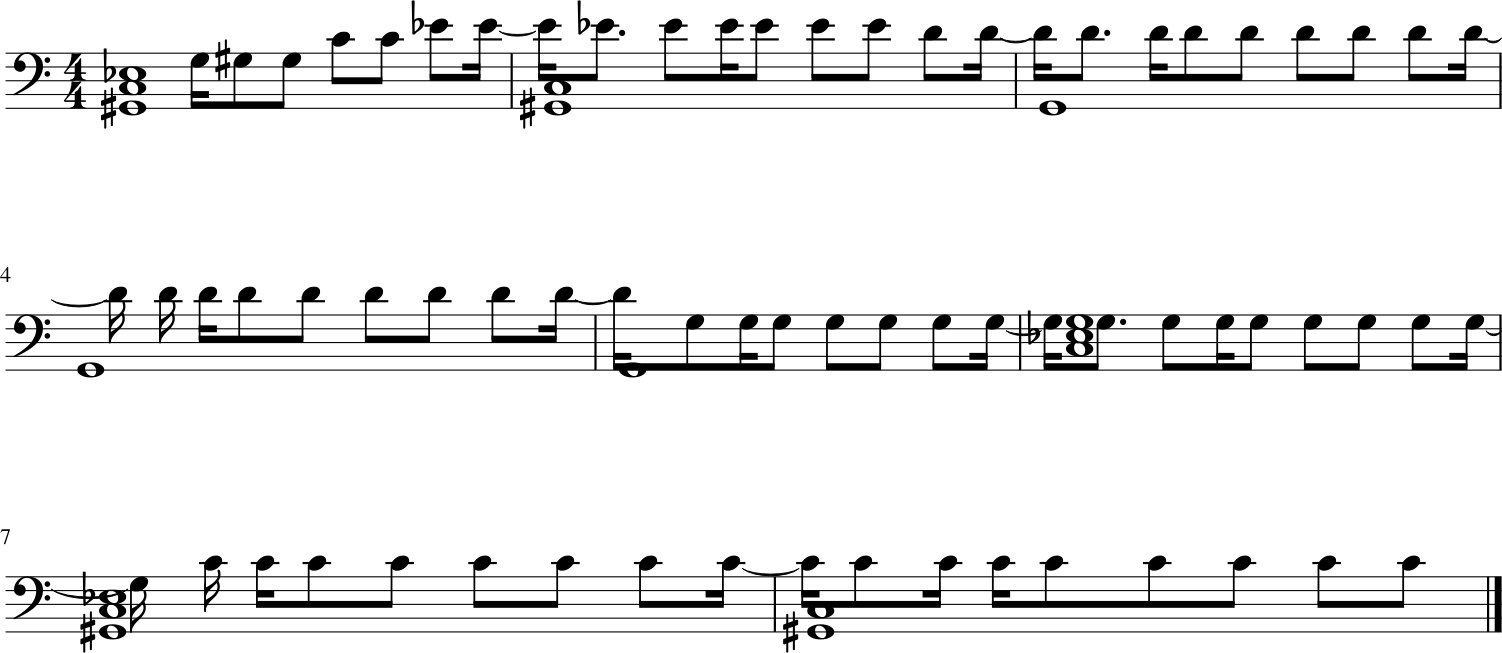

In [23]:
out.show()

## Prediction next word

In [24]:
seed_len = 4 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

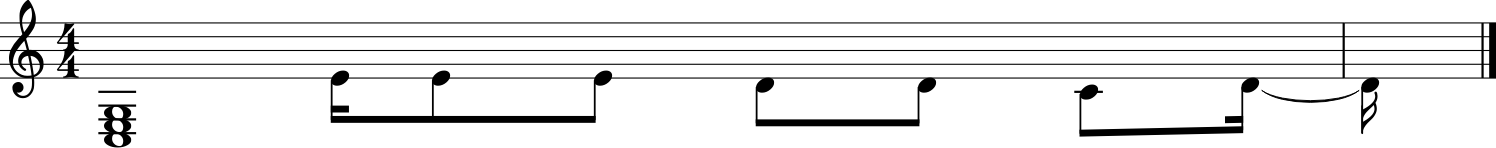

In [25]:
seed.show()

In [26]:
pred_nw = learn.predict_nw(seed, n_words=200)

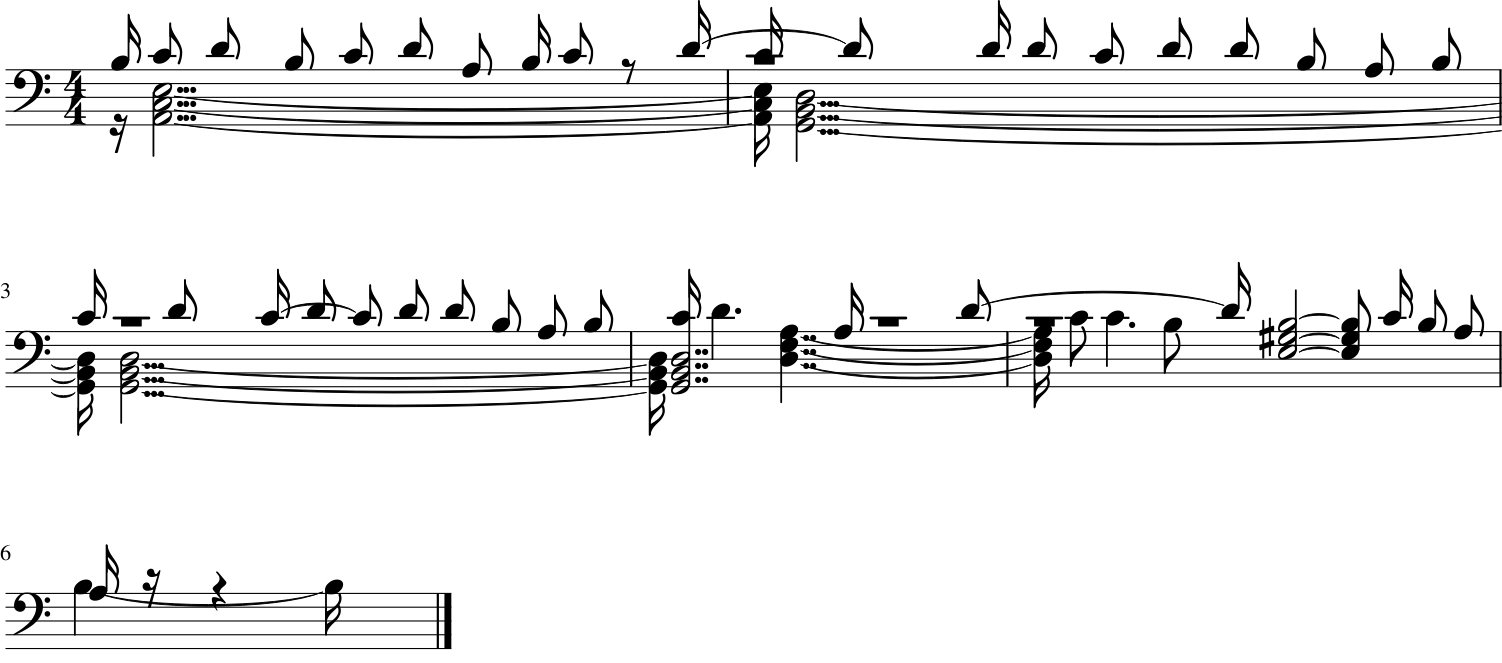

In [27]:
pred_nw.show()

In [28]:
pred_nw.play()

Convenience function

In [29]:
out = nw_predict_from_midi(learn, file, seed_len=seed_len, top_k=30, top_p=0.5)

Predicted BOS token. Returning prediction...


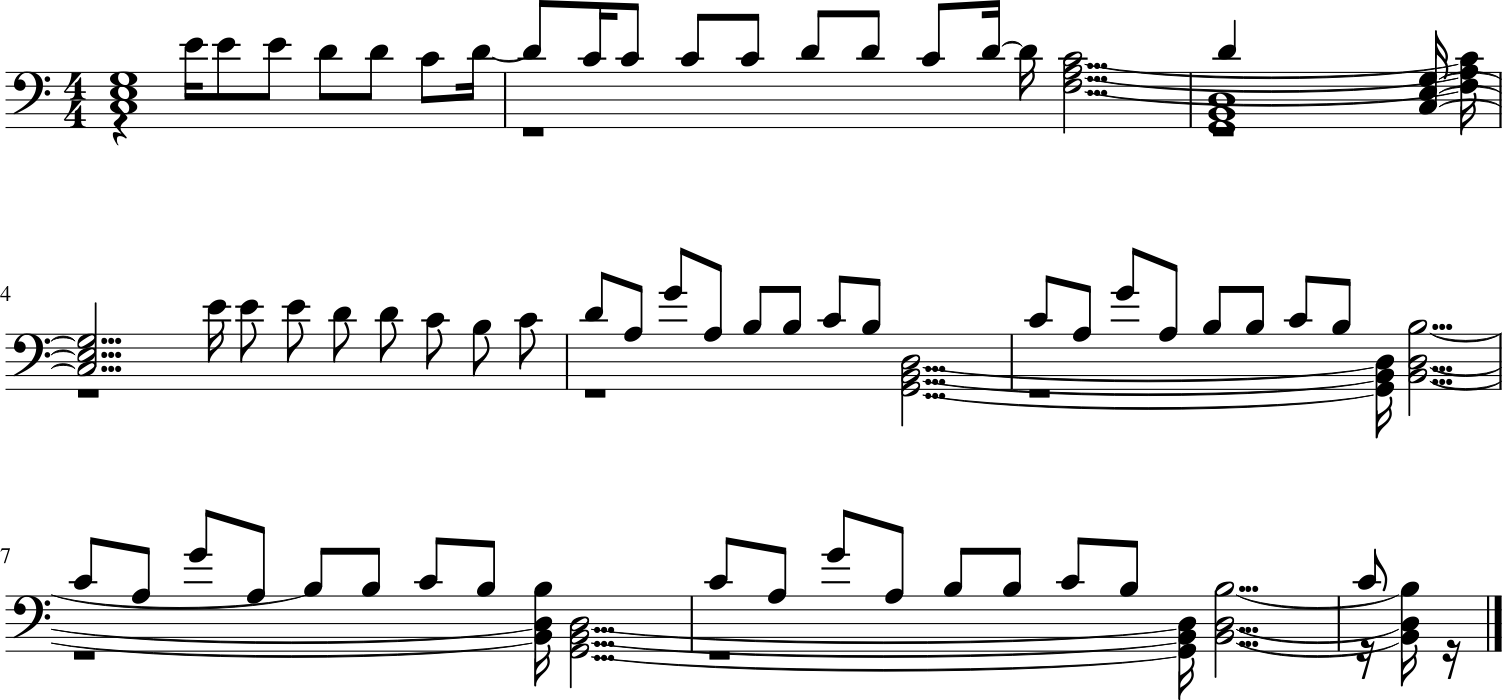

In [30]:
out.show()

## Predict Seq2Seq

In [38]:
from src.numpy_encode import stream2npenc_parts

In [42]:
multitrack_item = MultitrackItem.from_file(file, vocab)

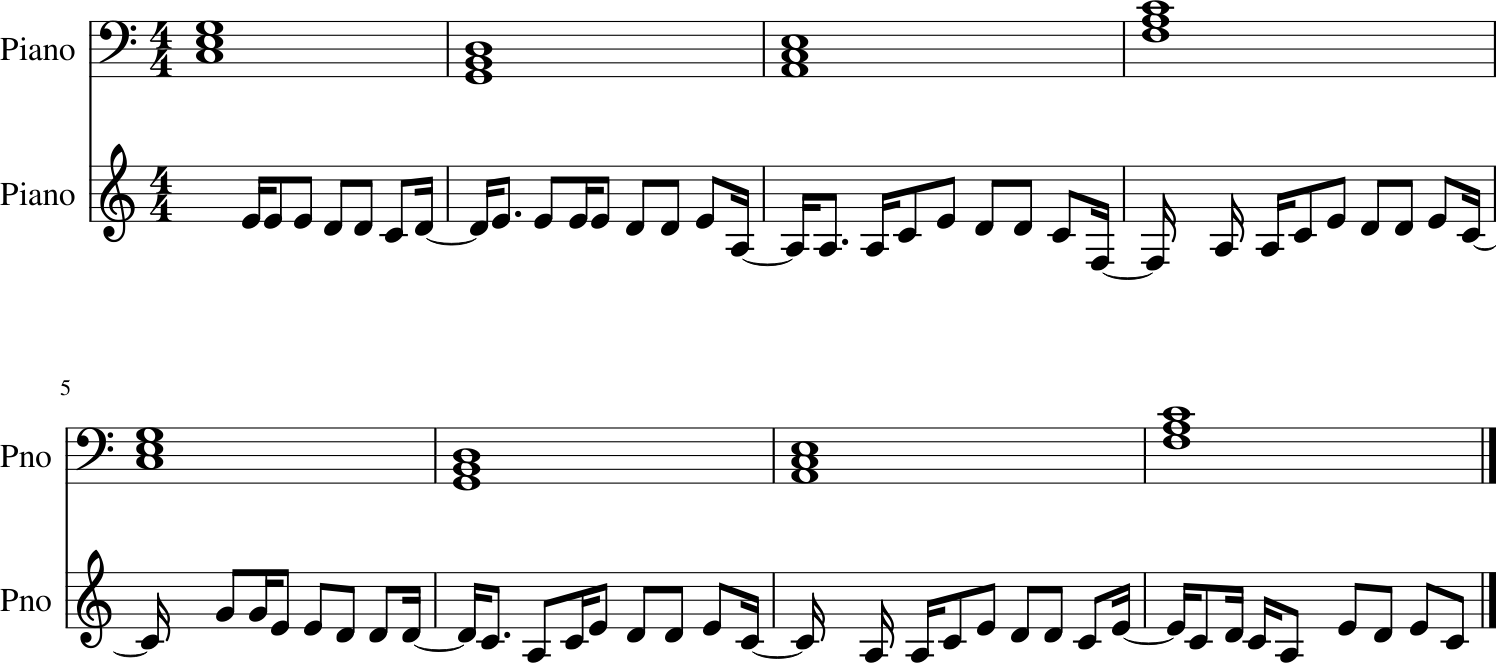

In [43]:
multitrack_item.show()

In [44]:
multitrack_item.play()

## Predict melody

In [40]:
partial_melody = trim_tfm(melody, vocab, to_beat=3)

In [41]:
idxenc2stream(melody_cut).show()

TypeError: idxenc2stream() missing 1 required positional argument: 'vocab'

In [ ]:
xb_msk = torch.tensor(chords).cuda()
xb_lm = torch.tensor(melody_cut).cuda()

In [ ]:
xb_msk.shape, xb_lm.shape

In [ ]:

def predict_s2s(self, xb_msk:Tensor, xb_lm:Tensor, n_words:int=128,
                temperatures:float=(1.0,1.0),
                top_k=30, top_p=0.8):
    self.model.reset()
    vocab = self.data.vocab
    x_lm = xb_lm.tolist()
    lm_pos = (neg_position_enc(xb_lm.cpu().numpy(), vocab)).tolist()
    last_pos = lm_pos[-1]

    msk_pos = torch.tensor(neg_position_enc(xb_msk.cpu().numpy(), vocab), device=xb_msk.device)
    x_enc = self.model.encoder(xb_msk.view(1, -1), msk_pos.view(1, -1))

    max_pos = msk_pos[-1] - SAMPLE_FREQ * 4

    with torch.no_grad():
        for i in progress_bar(range(n_words), leave=True):

            # Next Word
            x, pos = torch.tensor(x_lm, device=xb_lm.device)[None], torch.tensor(lm_pos, device=xb_lm.device)[None]
            dec = self.model.decoder(x, pos, x_enc) # all tasks include mask decoding
            res = F.softmax(self.model.head(dec), dim=-1)[-1, -1]

            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if (len(x_lm)==0 or vocab.is_duration(x_lm[-1])) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()
            #         idx = res.argmax()

            if idx == vocab.bos_idx | idx == vocab.stoi[EOS]: 
                print('Predicting BOS/EOS')
                break

            if x_lm and x_lm[-1]==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                last_pos = last_pos - duration # position is negative
                if last_pos < max_pos:
                    print('Predicted past counter-part length. Returning early')
                    break

            lm_pos.append(last_pos)
            x_lm.append(idx)

    return np.array(x_lm)


In [ ]:
out = learn.predict_s2s(xb_msk, xb_lm)

In [ ]:
idxenc2stream(out).show()

In [ ]:
chordarr_comb = s2s_combine2chordarr(out, chords)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [ ]:
comb_stream.show('midi')

## Predict chords

In [ ]:
chord_cut = seed_tfm(chords, seed_len=3)

In [ ]:
idxenc2stream(chord_cut).show()

In [31]:
xb_msk = torch.tensor(melody).cuda()
xb_lm = torch.tensor(chord_cut).cuda()

NameError: name 'melody' is not defined

In [32]:
xb_msk.shape, xb_lm.shape

NameError: name 'xb_msk' is not defined

In [33]:
out = learn.predict_s2s(xb_msk, xb_lm)

NameError: name 'xb_msk' is not defined

In [34]:
idxenc2stream(out).show()

TypeError: idxenc2stream() missing 1 required positional argument: 'vocab'

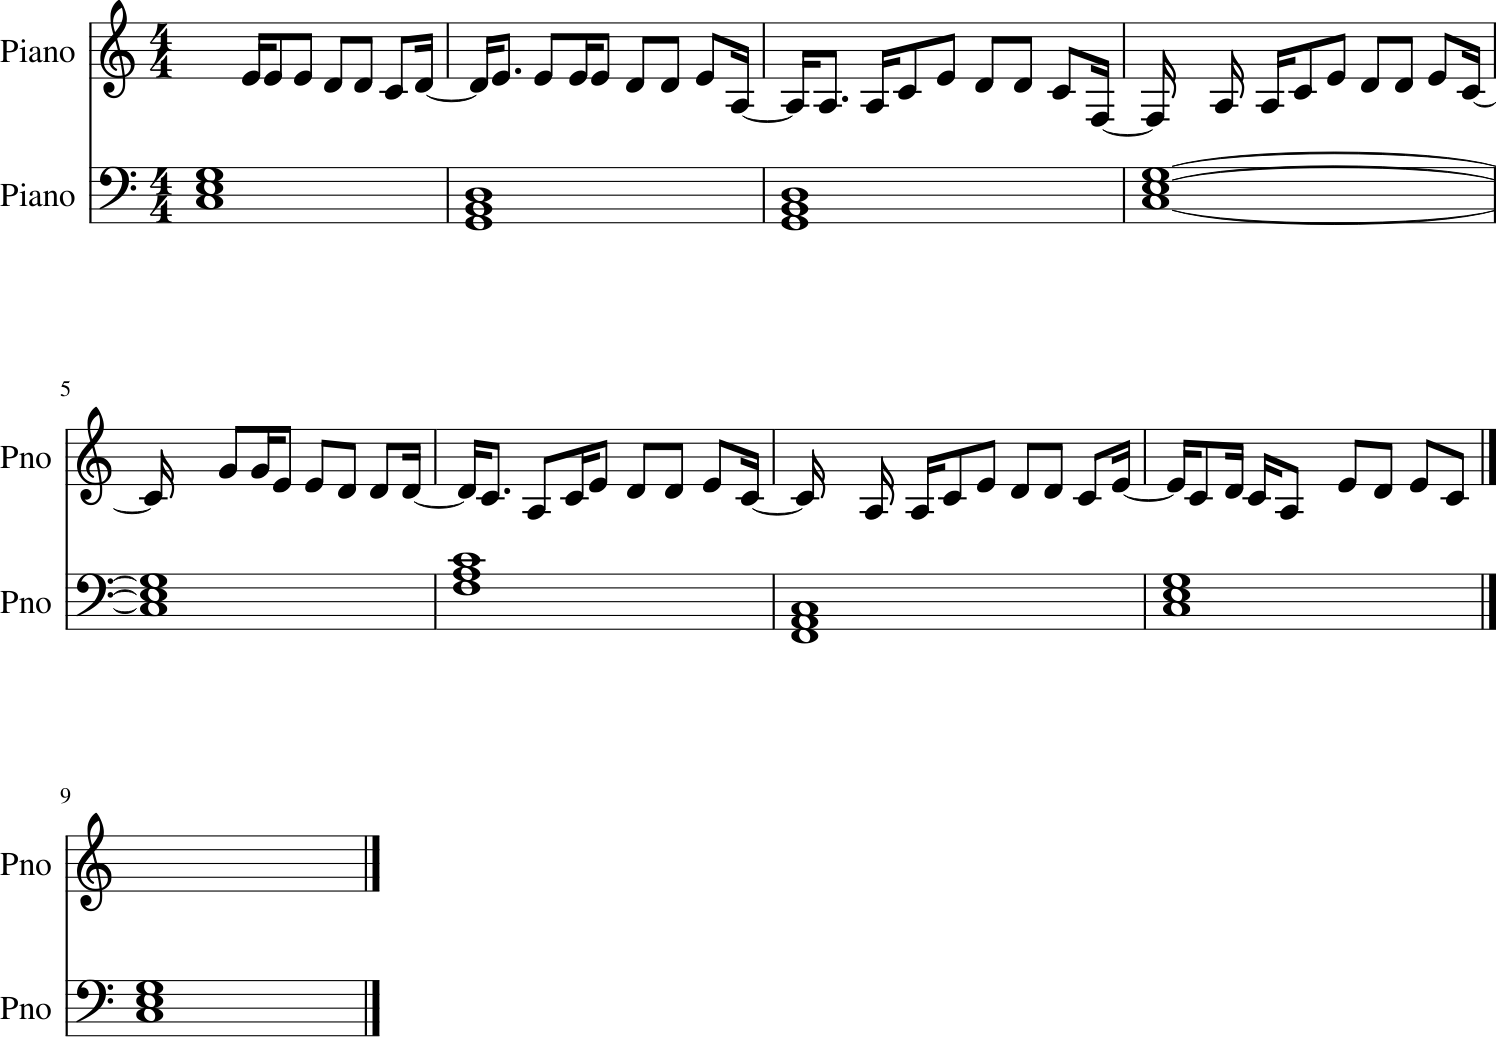

In [54]:
chordarr_comb = s2s_combine2chordarr(melody, out)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [55]:
comb_stream.show('midi')

Convenience Function

In [56]:
out = s2s_predict_from_midi(learn, file, seed_len=10)

Predicted past counter-part length. Returning early


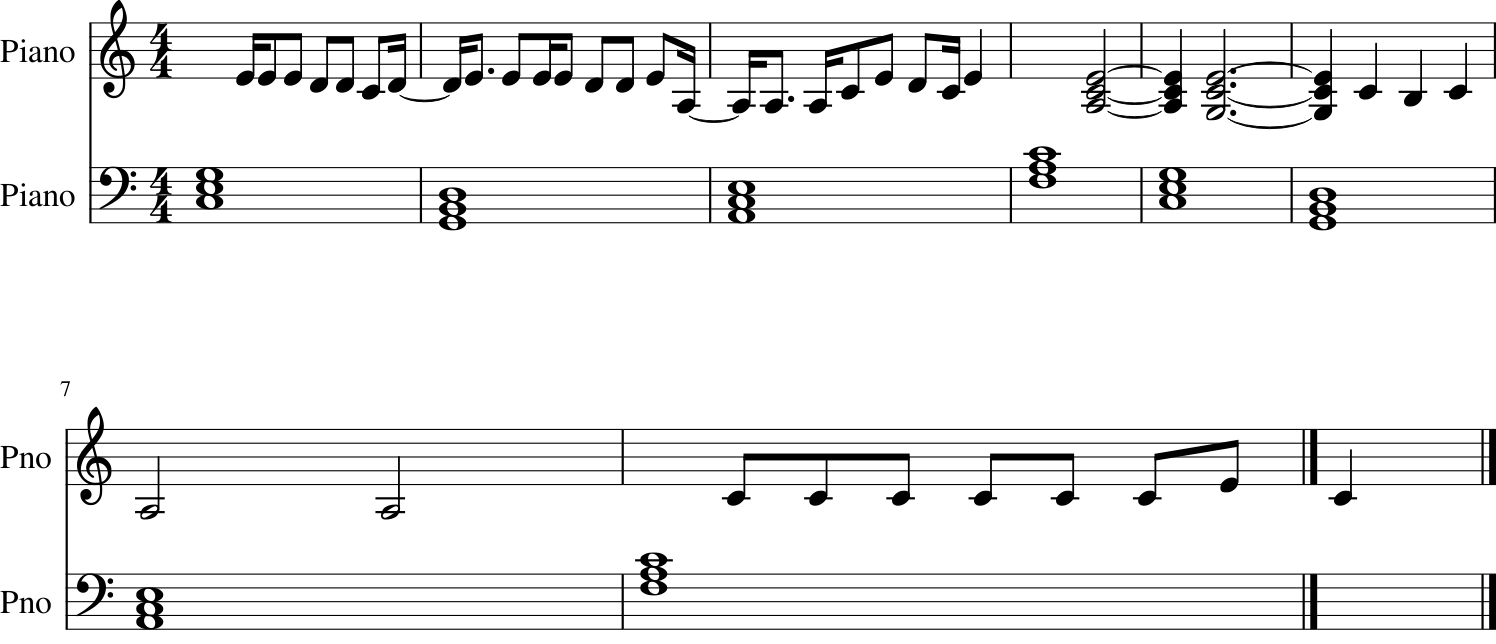

In [57]:
comb_stream = chordarr2stream(out, bpm=108)
comb_stream.show()